### **ИМПОРТ БИБЛИОТЕК**

In [274]:
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 

from datetime import datetime
import time

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split



Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### **ФУНКЦИИ**

In [275]:
def plt_gr(df):

  # функция рисует графики
  fig = plt.figure(figsize = (20,10))
  cols = df.columns
  sns.heatmap(df[cols].isna(), cmap = sns.color_palette())

In [276]:
def drop_corr_cols(data, th = 0.85):

  # Функция, удаляет столбцы коэффициент корреляуии между которыми выше порого th 
  a = data.corr().round(2).abs().unstack().sort_values()
  list_corr_col = []
  for index, val in a.items():
    if val >= th and index[0] != index[1] and index[1] not in list_corr_col:
      list_corr_col.append(index[0])
  set_list_corr_col = list(set(list_corr_col))
  data.drop(set_list_corr_col, inplace=True, axis=1)
  return data

In [277]:
def drop_cols_test(data, data_test):

  # Функция, удаляет столбцы из тестовой выборки, если этих столбцов нет в тренировочной
  col_drop_test = []
  for el in data_test.columns:
    if el not in data.columns:
      col_drop_test.append(el)
  data_test.drop(col_drop_test, inplace=True, axis=1)
  return data_test

In [278]:
def time_2ms(str_time):
  
  # Функция преобразует столбец, содержащий время, в секунды с  1 января 1970 года
  dt_end = datetime.strptime(str_time, "%Y-%m-%d %H:%M:%S")
  dt_start = datetime.strptime('1970-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
  dt_epoch = (dt_end - dt_start).total_seconds()
  return dt_epoch

### **ЗАГРУЗКА ДАТАСЕТА**

In [279]:
data_or  = pd.read_csv('/drive/MyDrive/ChemTech_Task/train_data_200k.csv')
data = data_or.copy()

target_cols = ['target1', 'target2', 'target3', 'target4']

In [280]:
data_test  = pd.read_csv('/drive/MyDrive/ChemTech_Task/test_data_100k.csv')

### **АНАЛИЗ ДАТАСЕТА**

In [281]:
data.iloc[:,1:].astype('float64')

tag1  tag2      tag3  tag4      tag5  tag6      tag7      tag8  \
0       15.78042   NaN       NaN   NaN       NaN   NaN       NaN       NaN   
1       15.80157   NaN       NaN   NaN       NaN   NaN  53.06440       NaN   
2       15.68913   NaN       NaN   NaN       NaN   NaN       NaN       NaN   
3       15.75101   NaN  20.26209   NaN       NaN   NaN  52.95166       NaN   
4       15.57773   NaN       NaN   NaN       NaN   NaN       NaN       NaN   
...          ...   ...       ...   ...       ...   ...       ...       ...   
199995  12.59146   NaN       NaN   NaN  49.92619   NaN       NaN  42.96059   
199996  12.66785   NaN       NaN   NaN       NaN   NaN  45.13568  42.03654   
199997  12.74665   NaN       NaN   NaN       NaN   NaN       NaN  41.70169   
199998  12.91019   NaN       NaN   NaN       NaN   NaN  44.72477  42.94123   
199999  12.95367   NaN       NaN   NaN  47.20922   NaN  45.67339  42.11330   

        tag9     tag10  ...     tag74     tag75     tag76     tag77     tag78  \
0        NaN  25.30402  ...  53.02723  66.30531  55.10297  73.65612       NaN   
1        NaN  25.30464  ...  53.05109  66.30098  55.11534       NaN       NaN   
2        NaN  25.30486  ...  53.06495  66.30359  55.09395       NaN       NaN   
3        NaN  25.30544  ...  53.06760  66.28421  55.12513       NaN  92.46913   
4        NaN  25.30540  ...  53.09679  66.26472  55.15526  73.67016       NaN   
...      ...       ...  ...       ...       ...       ...       ...       ...   
199995   NaN  18.52582  ...  36.58096  64.48034  45.11026  75.87032  93.66174   
199996   NaN  18.52569  ...  36.55834  64.48622  45.10105       NaN       NaN   
199997   NaN  18.52663  ...  36.60770  64.47961  45.07452       NaN       NaN   
199998   NaN  18.52538  ...  36.57269  64.47457  45.14655       NaN       NaN   
199999   NaN  18.52522  ...  36.57765  64.46373  45.22429  75.89020  93.76259   

           tag79   target1   target2   target3   target4  
0            NaN       NaN       NaN       NaN       NaN  
1            NaN       NaN       NaN       NaN       NaN  
2       55.07365       NaN       NaN       NaN       NaN  
3            NaN       NaN       NaN       NaN       NaN  
4            NaN       NaN       NaN       NaN       NaN  
...          ...       ...       ...       ...       ...  
199995       NaN  0.001514  0.065270  0.928968  0.004248  
199996  56.31732  0.001514  0.065273  0.928968  0.004245  
199997       NaN  0.001516  0.065336  0.928906  0.004242  
199998       NaN  0.001516  0.065333  0.928912  0.004239  
199999       NaN  0.001516  0.065331  0.928918  0.004236  

[200000 rows x 83 columns]

In [282]:
data

Unnamed: 0      tag1  tag2      tag3  tag4      tag5  tag6  \
0       2016-08-18 00:00:00  15.78042   NaN       NaN   NaN       NaN   NaN   
1       2016-08-18 00:01:00  15.80157   NaN       NaN   NaN       NaN   NaN   
2       2016-08-18 00:02:00  15.68913   NaN       NaN   NaN       NaN   NaN   
3       2016-08-18 00:03:00  15.75101   NaN  20.26209   NaN       NaN   NaN   
4       2016-08-18 00:04:00  15.57773   NaN       NaN   NaN       NaN   NaN   
...                     ...       ...   ...       ...   ...       ...   ...   
199995  2017-01-03 21:15:00  12.59146   NaN       NaN   NaN  49.92619   NaN   
199996  2017-01-03 21:16:00  12.66785   NaN       NaN   NaN       NaN   NaN   
199997  2017-01-03 21:17:00  12.74665   NaN       NaN   NaN       NaN   NaN   
199998  2017-01-03 21:18:00  12.91019   NaN       NaN   NaN       NaN   NaN   
199999  2017-01-03 21:19:00  12.95367   NaN       NaN   NaN  47.20922   NaN   

            tag7      tag8  tag9  ...     tag74     tag75     tag76     tag77  \
0            NaN       NaN   NaN  ...  53.02723  66.30531  55.10297  73.65612   
1       53.06440       NaN   NaN  ...  53.05109  66.30098  55.11534       NaN   
2            NaN       NaN   NaN  ...  53.06495  66.30359  55.09395       NaN   
3       52.95166       NaN   NaN  ...  53.06760  66.28421  55.12513       NaN   
4            NaN       NaN   NaN  ...  53.09679  66.26472  55.15526  73.67016   
...          ...       ...   ...  ...       ...       ...       ...       ...   
199995       NaN  42.96059   NaN  ...  36.58096  64.48034  45.11026  75.87032   
199996  45.13568  42.03654   NaN  ...  36.55834  64.48622  45.10105       NaN   
199997       NaN  41.70169   NaN  ...  36.60770  64.47961  45.07452       NaN   
199998  44.72477  42.94123   NaN  ...  36.57269  64.47457  45.14655       NaN   
199999  45.67339  42.11330   NaN  ...  36.57765  64.46373  45.22429  75.89020   

           tag78     tag79   target1   target2   target3   target4  
0            NaN       NaN       NaN       NaN       NaN       NaN  
1            NaN       NaN       NaN       NaN       NaN       NaN  
2            NaN  55.07365       NaN       NaN       NaN       NaN  
3       92.46913       NaN       NaN       NaN       NaN       NaN  
4            NaN       NaN       NaN       NaN       NaN       NaN  
...          ...       ...       ...       ...       ...       ...  
199995  93.66174       NaN  0.001514  0.065270  0.928968  0.004248  
199996       NaN  56.31732  0.001514  0.065273  0.928968  0.004245  
199997       NaN       NaN  0.001516  0.065336  0.928906  0.004242  
199998       NaN       NaN  0.001516  0.065333  0.928912  0.004239  
199999  93.76259       NaN  0.001516  0.065331  0.928918  0.004236  

[200000 rows x 84 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ea773bd90>,
      dtype=object)

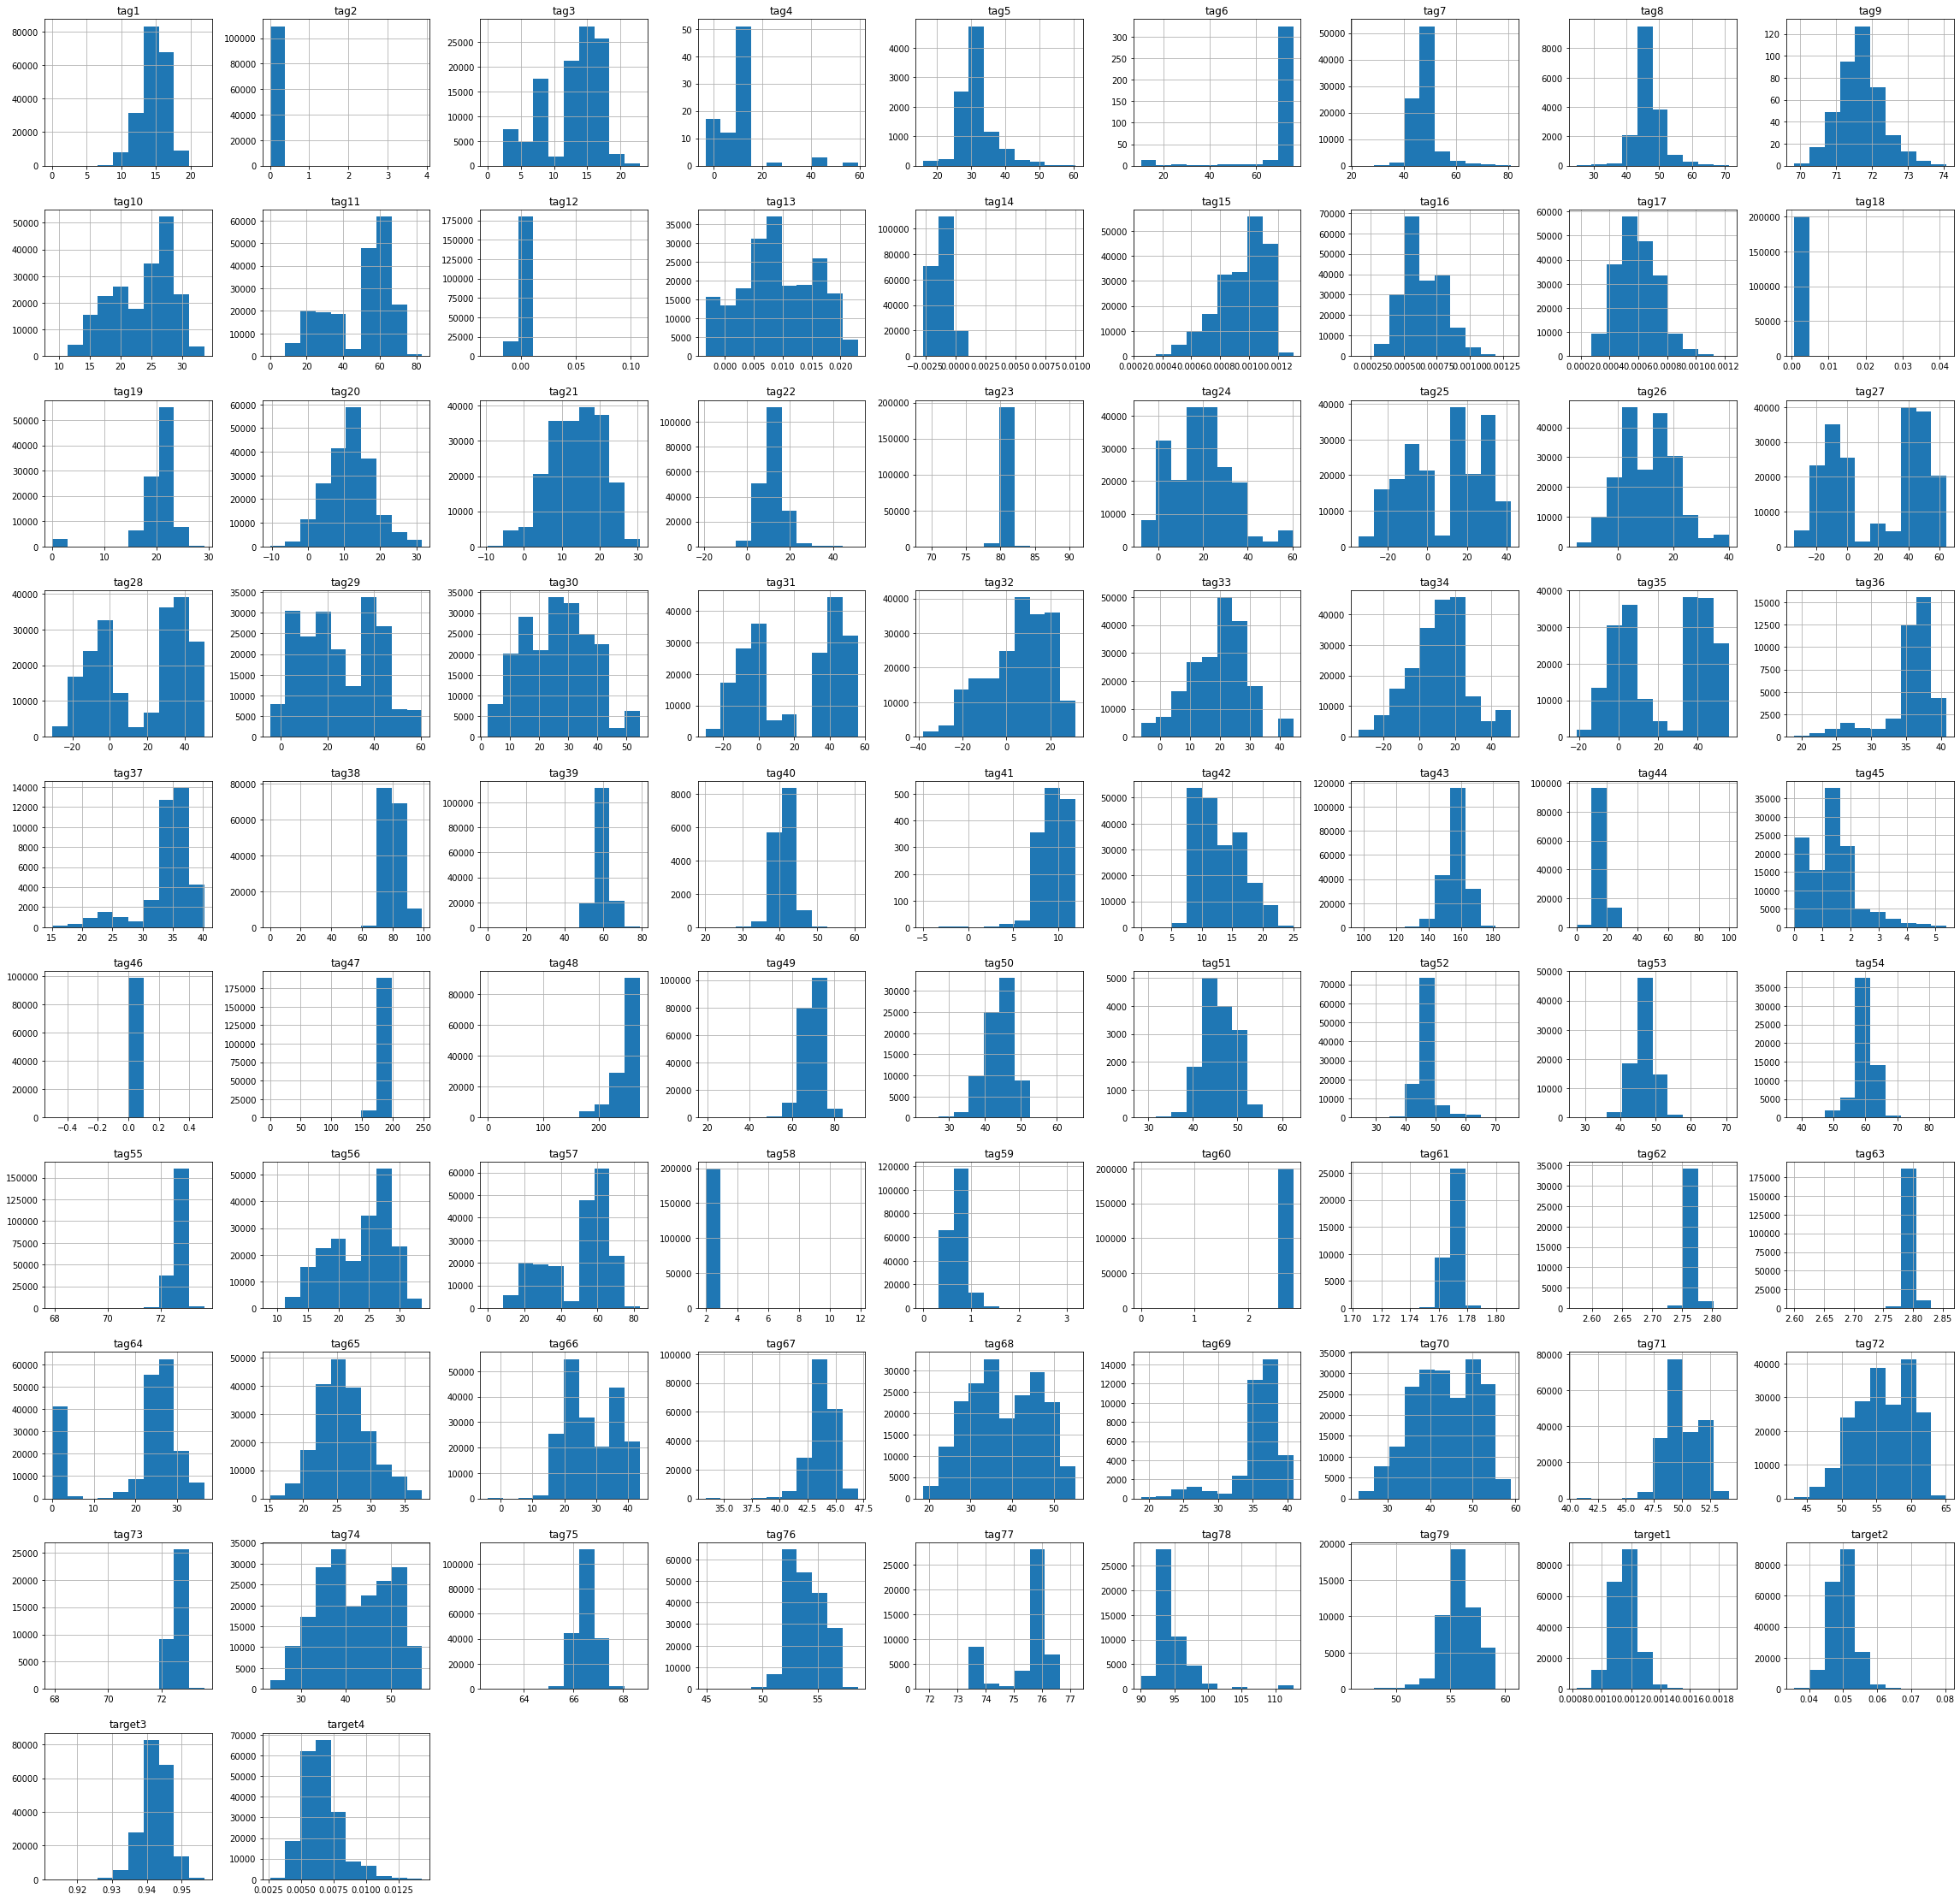

In [283]:
data.hist(figsize = (40,40))

По данным гистограммам можно сказать, что данные имеют разномасштабный характер. И в данных присутствуют как положительные, так и отрицательные значения

#### УДАЛЕНИЕ ДУБЛИКАТОВ

In [284]:
data.shape

(200000, 84)

In [285]:
data.drop_duplicates(inplace=True)
data.shape

(200000, 84)

Дубликатов в датасете нет

#### ОБРАБОТКА NAN ЗНАЧЕНИЙ

In [286]:
data_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 84 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  200000 non-null  object 
 1   tag1        199934 non-null  float64
 2   tag2        109370 non-null  float64
 3   tag3        109456 non-null  float64
 4   tag4        85 non-null      float64
 5   tag5        9736 non-null    float64
 6   tag6        373 non-null     float64
 7   tag7        88122 non-null   float64
 8   tag8        16777 non-null   float64
 9   tag9        407 non-null     float64
 10  tag10       199837 non-null  float64
 11  tag11       199867 non-null  float64
 12  tag12       199875 non-null  float64
 13  tag13       199875 non-null  float64
 14  tag14       199875 non-null  float64
 15  tag15       199875 non-null  float64
 16  tag16       199875 non-null  float64
 17  tag17       199875 non-null  float64
 18  tag18       199875 non-null  float64
 19  ta

Во всех столбцах, кроме 'Unnamed: 0' имеются пропущенные значения. В том числе и в таргетах

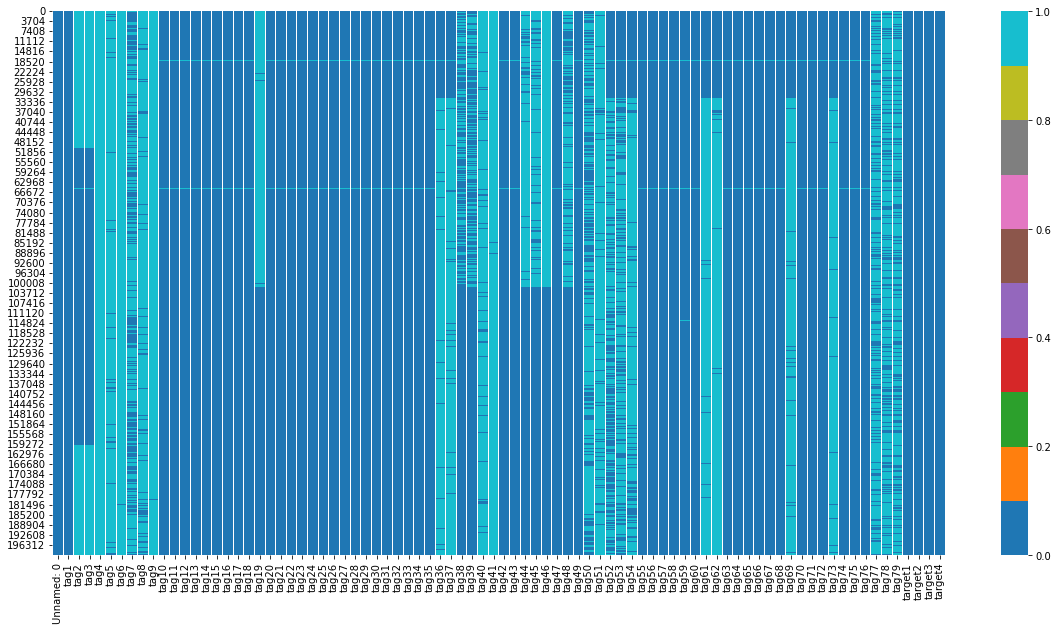

In [287]:
# Исследуем датасет на наличие нулей
plt_gr(data_or)

По данной диаграмме заметно в некоторых столбцах закономерность распределения NaN значений. По этим данным мы можем предположить, что распределение NaN не равномерно в некоторых столбцах, а значит эти значения не случайны и на них действует какой-то общий признак. 

Можно предположить, что это отсуствие каких-то значений на приборе.

In [288]:
# Поскольку в таргетах находятся тоже неизвестные значения и их достаточно мало, можем удалить эти строки
for target in target_cols:
  data = data.loc[~data[target].isna()]

# Колонки, которые заполнены неравномерно заполним нулями
fill_cols_null = ['tag19', 'tag36', 'tag37','tag38', 'tag39', 'tag44', 'tag45', 'tag46', 'tag48', 'tag52', 'tag53', 'tag54', 'tag61', 'tag62', 'tag69', 'tag73']
data[fill_cols_null] = data[fill_cols_null].fillna(0)
data_test[fill_cols_null] = data_test[fill_cols_null].fillna(0)


# Остальные колонки заполним c помощью линейной интерполяции
data = data.interpolate(method='linear')
data = data.fillna(data.median())
data_test = data_test.fillna(data.median())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [289]:
data.shape

(199991, 84)

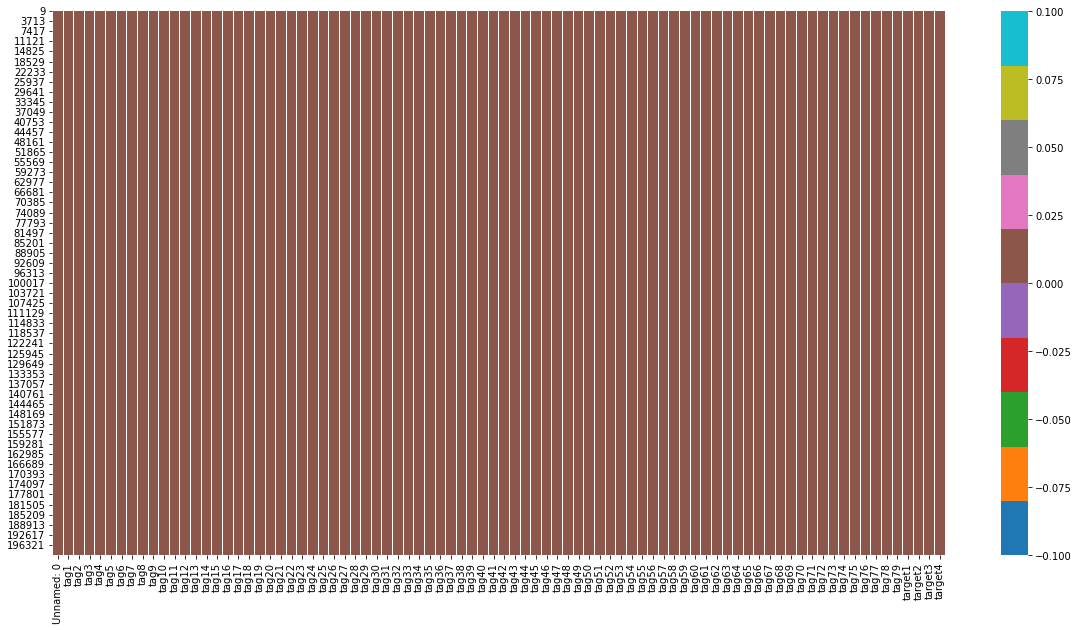

In [290]:
# Визуально отобразим отсутсвие NaN значений
plt_gr(data)

#### ИССЛЕДОВАНИЕ КОРРЕЛЯЦИИ МЕЖДУ ПРИЗНАКАМИ

Построим матрицу корреляции между признаками

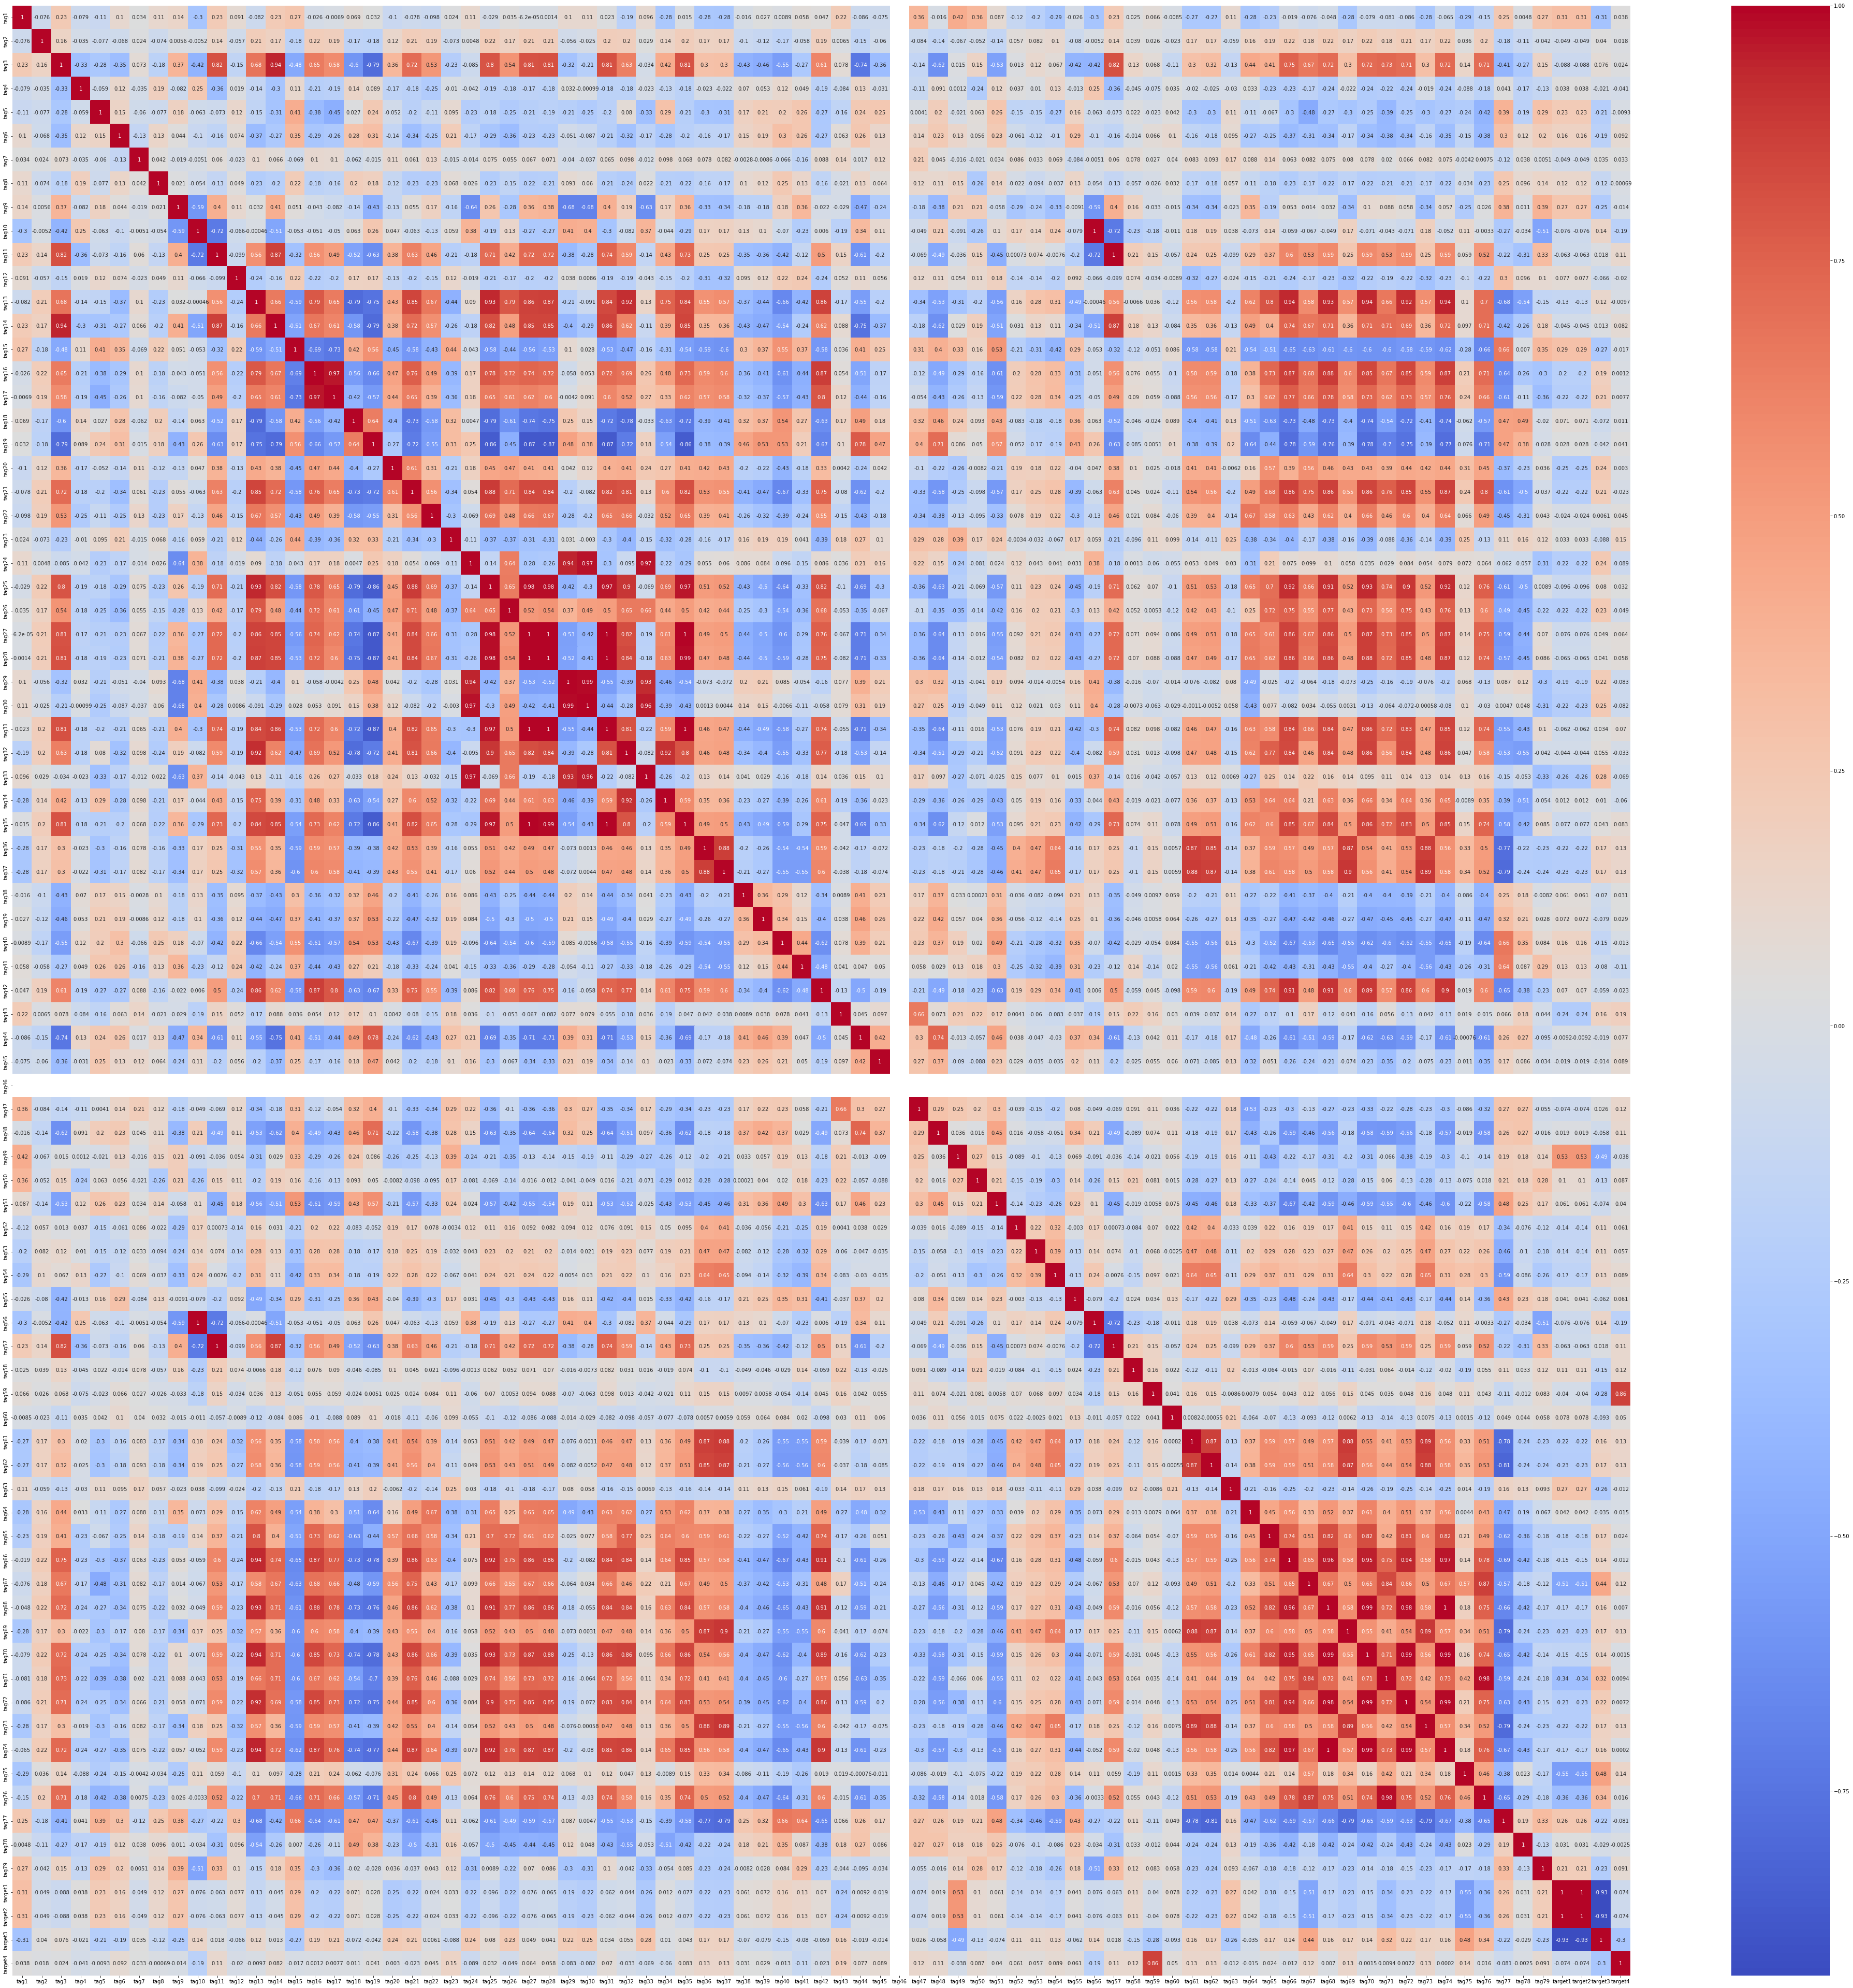

In [291]:
plt.figure(figsize=(70,70))
sns.heatmap(data.corr(),  annot = True, cmap= 'coolwarm')

По данным матрицы можем визуально определить, что между некоторыми признаками наблюдается достаточно сильная корреляция

In [292]:
target = data[target_cols]
#После обработки удаляем таргеты из датасета
data.drop(target_cols, inplace=True, axis=1)

In [293]:
# Удалим столбцы которые сильно коррелируют между собой
data = drop_corr_cols(data, th = 0.85)

# Так же удалим столбец 'tag46', поскольку там содержатся только нули

data.drop(['tag46'], inplace=True, axis=1)

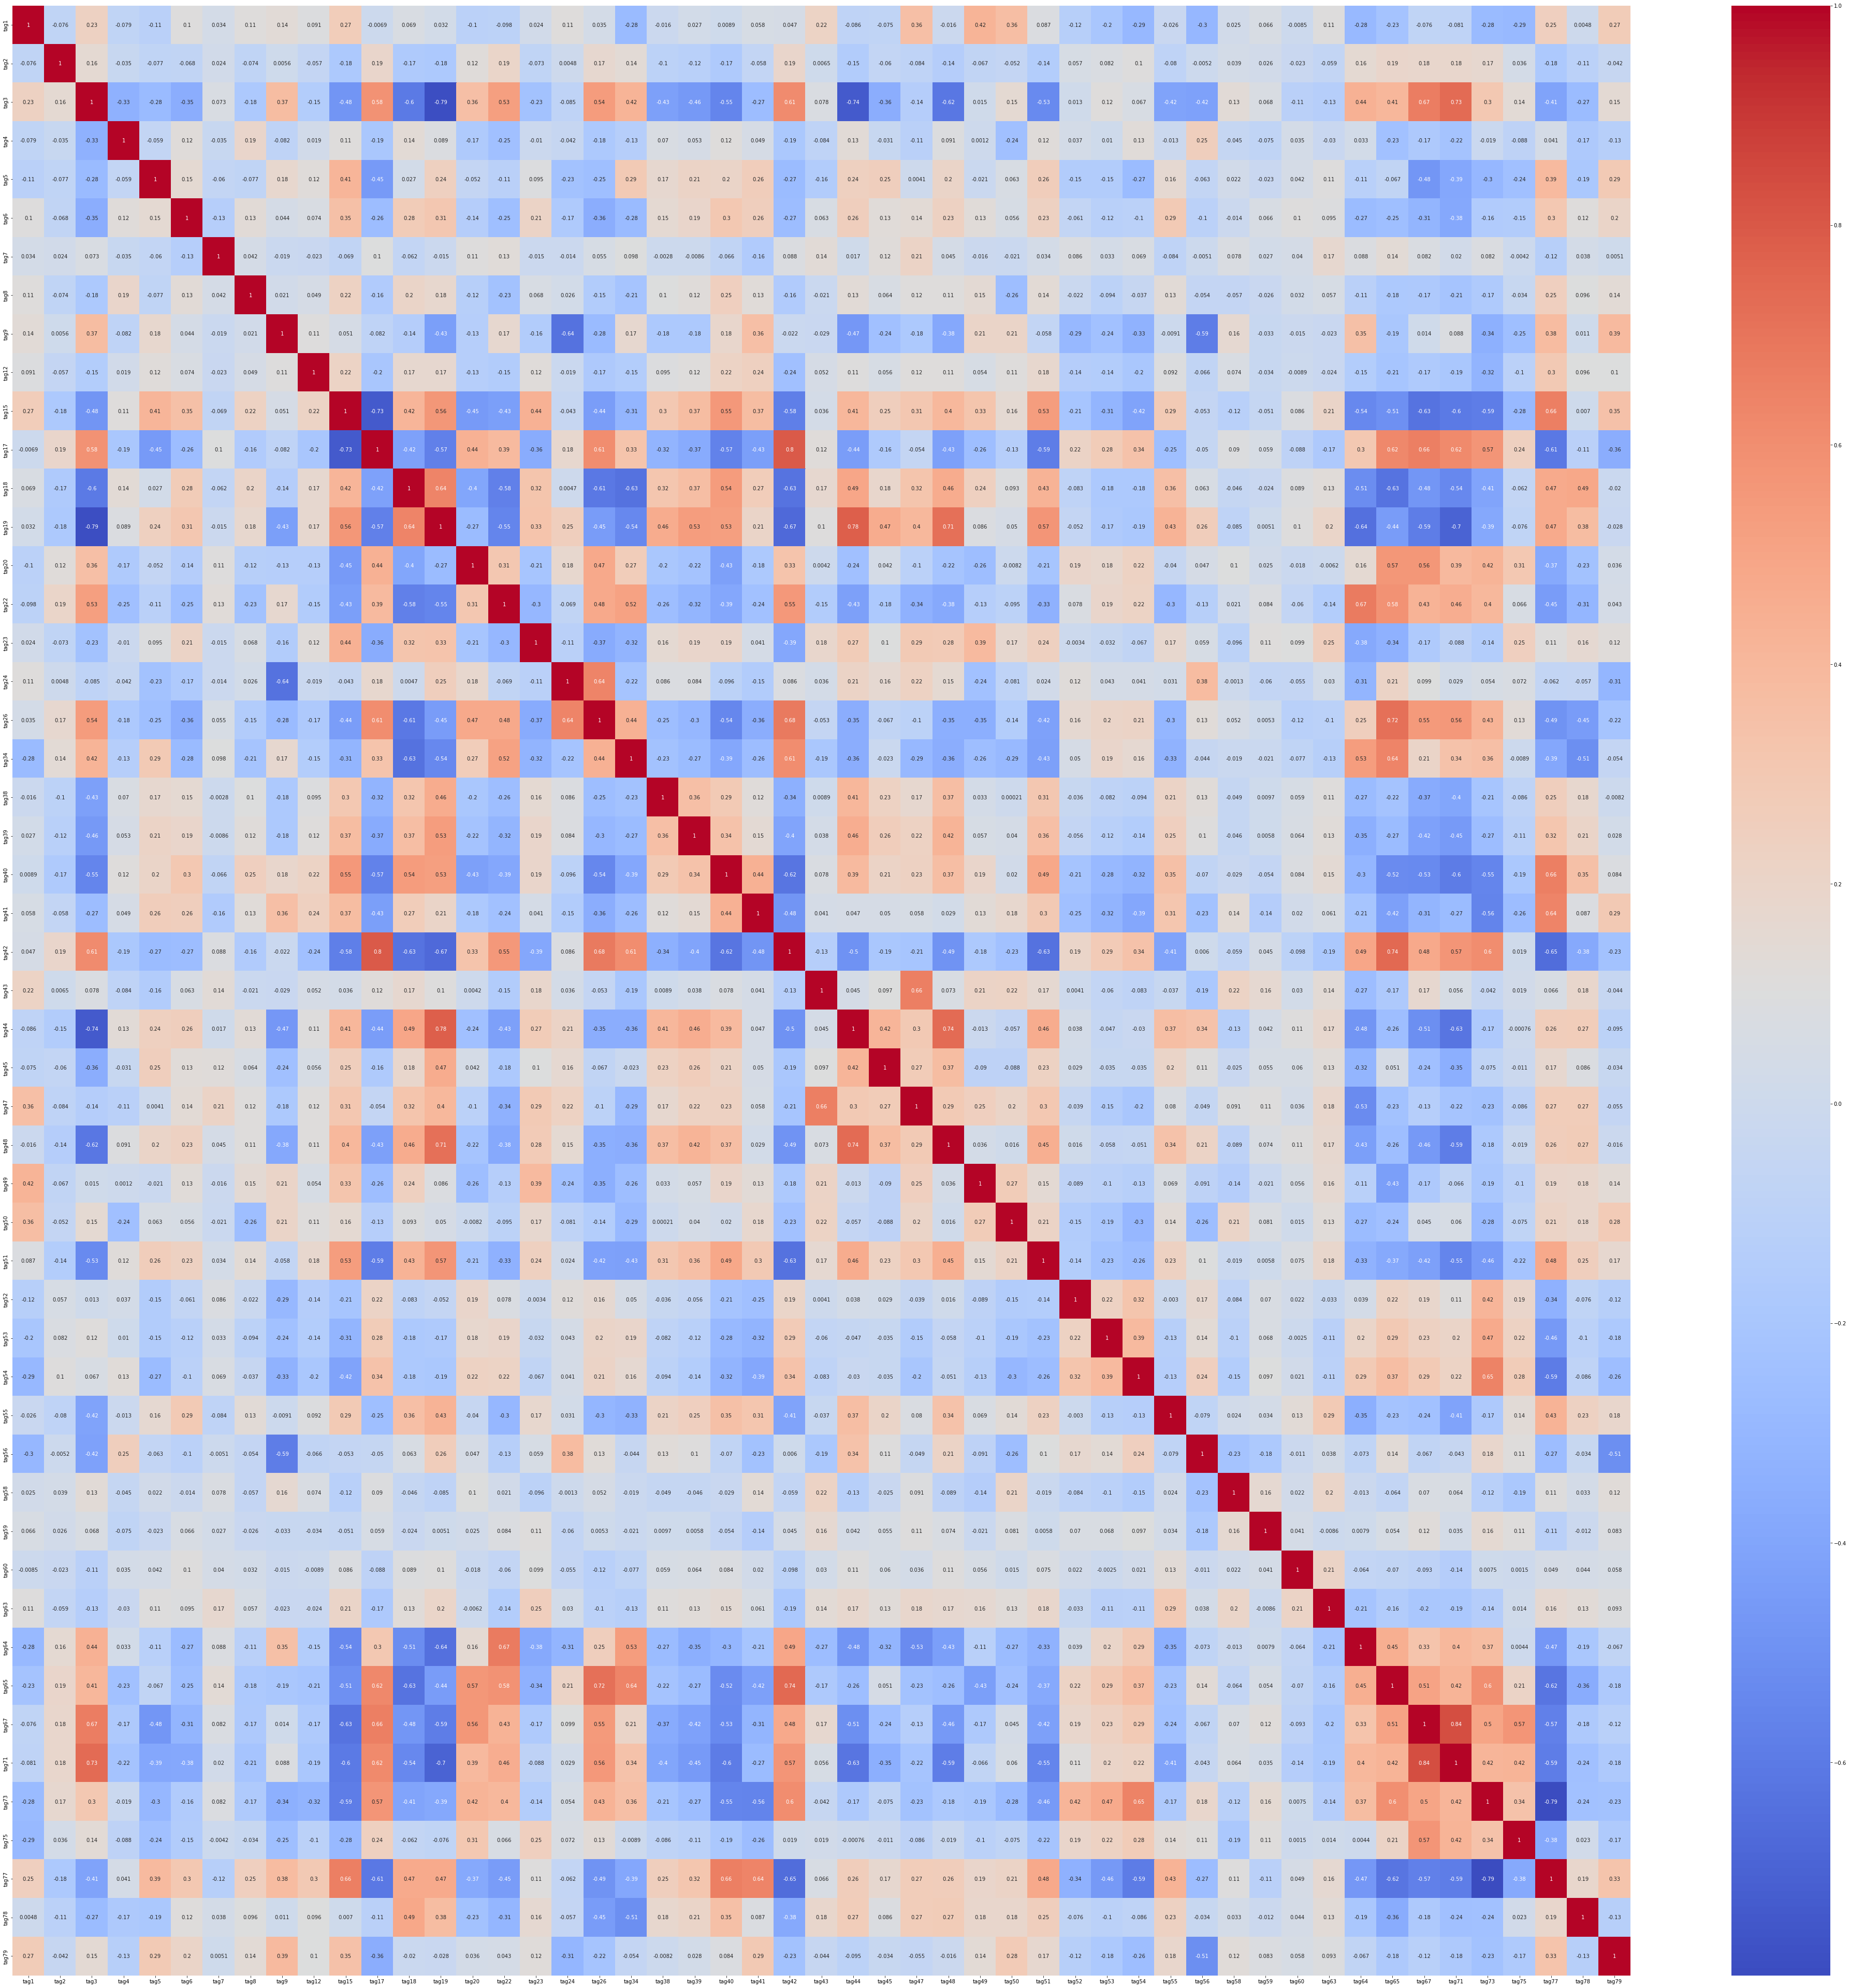

In [294]:
plt.figure(figsize=(70,70))
sns.heatmap(data.corr(),  annot = True, cmap= 'coolwarm')

Видим результат удаления лишних столбцов.

#### НОРМАЛИЗАЦИЯ ДАННЫХ

Поскольку данные имеют разный масштаб, их необходимо нормализовать

In [295]:
# Оставим в тестовой выборке те же столбцы,что и в тренировочной
data_test = drop_cols_test(data, data_test)

In [296]:
# Соединим тренировочную и тестовую выборки для удобства нормализации
full_data = pd.concat([data, data_test])

In [297]:
# Нормализуем стобец в котором содержится время
full_data['Unnamed: 0'] = full_data['Unnamed: 0'].apply(time_2ms)


In [298]:
full_data.rename(columns = {'Unnamed: 0' : 'Time'}, inplace = True)

In [299]:
# Нормализуем остальные данные
scaler = MinMaxScaler()
norm_data=pd.DataFrame(scaler.fit_transform(full_data),
            columns=full_data.columns, index=full_data.index)

In [300]:
# После нормализации снова разделяем выборки на тестовую и тренировочную
data = norm_data.loc[:199999,:]
data_test = norm_data.loc[0:,:]

### **ПОСТРОЕНИЕ МОДЕЛЕЙ**

#### Ridge_Pipeline_Model

In [301]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=0)

In [302]:
def modelling_Ridge_Pipeline():

  dict_predict = {}

  for tgt in target.columns:
    model = make_pipeline(PolynomialFeatures(degree=1), Ridge(alpha=0.2))
    model_fit = model.fit(X_train, y_train[tgt])

    # предсказание на выборке валидации
    val_pred = model_fit.predict(X_val)

    #Вычисление метрик
    score = model_fit.score(X_val, y_val[tgt])
    mse = mean_squared_error(y_val[tgt], val_pred)
    print(f'Таргет {tgt}\n'
          f'Pipeline model score: {score}\n'
          f'Pipeline model mse: {mse}\n')

    # предсказание на тестовой выборке
    predict_test = model_fit.predict(data_test)
    dict_predict[tgt] = predict_test
    predict = pd.DataFrame(dict_predict, columns=target.columns)

    predict.to_csv(r'test_predict_RP.csv')


modelling_Ridge_Pipeline()

Таргет target1
Pipeline model score: 0.841601791440985
Pipeline model mse: 1.1601293308801466e-09

Таргет target2
Pipeline model score: 0.8416559068403647
Pipeline model mse: 2.1544889717754953e-06

Таргет target3
Pipeline model score: 0.8139289785271364
Pipeline model mse: 2.884533165161181e-06

Таргет target4
Pipeline model score: 0.8013065712744946
Pipeline model mse: 4.1031397126032237e-07



#### MultiOutputRegressor

In [303]:
def modelling_MultiOutRegr():
  # обучение модели
  model = MultiOutputRegressor(Ridge(random_state=123))
  model_fit = model.fit(X_train, y_train)

  # предсказание на выборке валидации
  val_pred = model_fit.predict(X_val)
  score = model_fit.score(X_val, y_val)
  mse = mean_squared_error(y_val, val_pred)
  print(f'MultiOutputRegressor score: {score}\n'
        f'MultiOutputRegressor mse: {mse}\n')

  # предсказание на тестовой выборке
  predict = pd.DataFrame(model_fit.predict(data_test), columns=target.columns)

  predict.to_csv(r'test_predict_MOR.csv')
  

modelling_MultiOutRegr()

MultiOutputRegressor score: 0.8185316242519631
MultiOutputRegressor mse: 1.4202142362260766e-06



### **ТОП-10 ЗНАЧИМЫХ ТЕГОВ**

In [304]:
target

target1   target2   target3   target4
9       0.001120  0.048361  0.944454  0.006065
10      0.001122  0.048368  0.944445  0.006065
11      0.001122  0.048355  0.944459  0.006064
12      0.001120  0.048259  0.944559  0.006063
13      0.001123  0.048399  0.944415  0.006062
...          ...       ...       ...       ...
199995  0.001514  0.065270  0.928968  0.004248
199996  0.001514  0.065273  0.928968  0.004245
199997  0.001516  0.065336  0.928906  0.004242
199998  0.001516  0.065333  0.928912  0.004239
199999  0.001516  0.065331  0.928918  0.004236

[199991 rows x 4 columns]

In [305]:
def get_top_importance_tags(X_train, y_train, target, size=0.20):

  dict_importance = {}

  for tgt in target.columns:
    model = make_pipeline(Ridge(alpha=0.2))
    model_fit = model.fit(X_train, y_train[tgt])

    X_train_preprocessed = model.named_steps["ridge"].coef_

    dict_importance[tgt] = X_train_preprocessed

  top_tags = pd.DataFrame(dict_importance, index=X_train.columns)

  top_10_tags = top_tags.median(axis=1).sort_values(ascending=False).head(10)
  
  top_10_tags.to_csv(r'top_10_tags.csv')

  return top_10_tags


In [306]:
top_10_tags = get_top_importance_tags(X_train, y_train, target)
top_10_tags

tag23    0.001641
tag59    0.001177
tag67    0.000835
tag2     0.000705
tag26    0.000631
Time     0.000625
tag47    0.000613
tag9     0.000609
tag8     0.000469
tag43    0.000441
dtype: float64

Text(0.5, 1.0, 'Топ 10 значимых тегов')

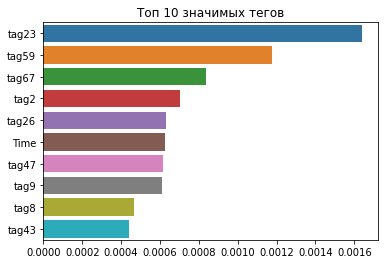

In [307]:
sns.barplot(x =top_10_tags, y=top_10_tags.index)
plt.title("Топ 10 значимых тегов")
